# Homework 3 - Ames Housing Dataset

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from scipy.stats import zscore
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import DistanceMetric
import warnings
warnings.filterwarnings('ignore')

In [146]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
cd '/content/drive/My Drive/DSF HW3/'

/content/drive/My Drive/DSF HW3


In [0]:
df = pd.read_csv('train.csv')

In [0]:
df1 = df

df1['FullBathrooms'] = df1['FullBath'] + df1['BsmtFullBath']
df1['HalfBathrooms'] = df1['HalfBath'] + df1['BsmtHalfBath']

In [0]:
df1.drop('FullBath', axis=1, inplace = True)
df1.drop('HalfBath', axis=1, inplace = True)
df1.drop('BsmtFullBath', axis=1, inplace = True)
df1.drop('BsmtHalfBath', axis=1, inplace = True)

In [94]:
df1.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,FullBathrooms,HalfBathrooms
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,3,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,3,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,2,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,3,1


In [0]:
map1 = ['SalePrice','LotArea', 'YearBuilt', 'BedroomAbvGr', 'FullBathrooms', 'HalfBathrooms', 'TotRmsAbvGrd', 'Foundation', 'OverallQual', 'OverallCond', 
        'KitchenAbvGr', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'YearRemodAdd']
df_heatmap = df1[map1]

## Part 1 - Pairwise Correlations

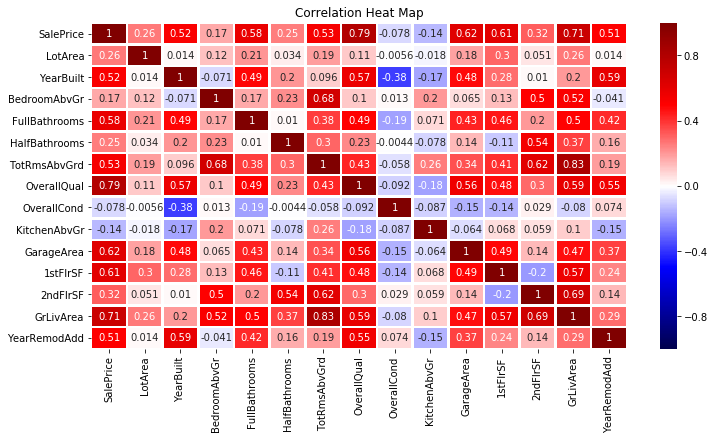

In [85]:
# TODO: show visualization
plt.figure(figsize = (12,6))
ax = sns.heatmap(df_heatmap.corr(), vmin=-1, vmax=1, cmap='seismic', linewidths=1.6, annot=True)
plt.title('Correlation Heat Map')
plt.show()

Discuss most positive and negative correlations.




1. From the heatmap, we can see that the 'OverallCondition' variable is very strongly negatively correlated with the 'YearBuilt' variable. Intuitively, this makes sense as older houses will probably be in a worse condition. 

2. A few obvious strong positive correlations are the total rooms above ground level to the square feet of the second floor. It is safe to assume that the square footage will increase based on the number of rooms in the house.
3. Coming to SalePrice, we can see that Overall Quality of the house, Ground Living Area, and Total Rooms above Ground are all highly correlated with the selling price of the house. This definitely makes sense intuitively as one would expect a larger house, with high quality and a lot of rooms would sell higher, barring the exceptions of outliers



## Part 2 - Informative Plots

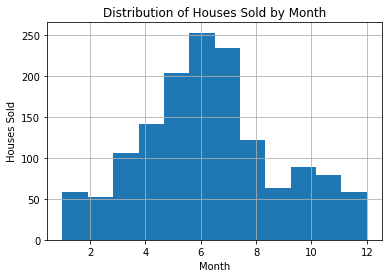

In [17]:
# TODO: code to generate Plot 1
plt.figure(figsize= (6,4))
df1.MoSold.hist(bins = 12)
plt.title('Distribution of Houses Sold by Month')
plt.xlabel('Month')
plt.ylabel('Houses Sold')
plt.show()

What interesting properties does Plot 1 reveal?

From this distribution, we can see that the number of houses sold is particulrarly high in the months from May to July. Intuitively, this might be due to the fact that this range is the season for people to buy houses. This may be due to various factors and weather(Summer) may also be one of these factors. Nonetheless, it is interesting to see that the number of houses sold are significantly concentrated in this 3 month span. 

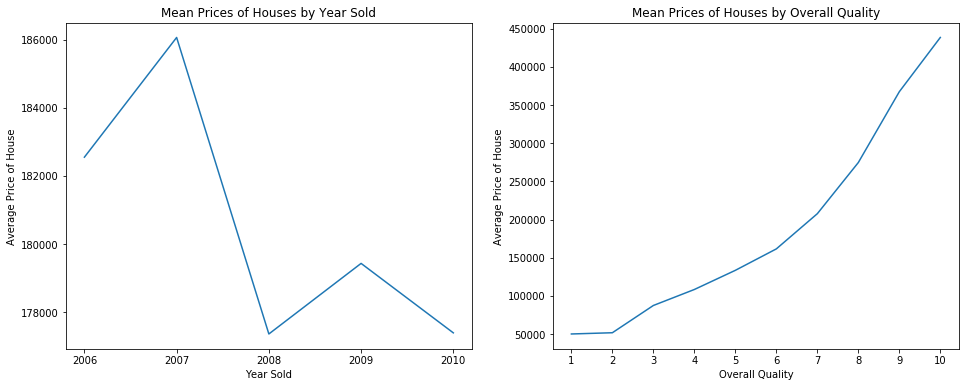

In [35]:
# TODO: code to generate Plot 2
mean_prices = []
years = []
for year in df1.YrSold.unique():
  temp = df1[df1.YrSold == year]
  mean_prices.append(temp['SalePrice'].mean())
  years.append(int(year))
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.lineplot(x = years, y = mean_prices, sort = True, )
ax.set(xticks= years)
plt.xlabel("Year Sold")
plt.ylabel("Average Price of House")
plt.title("Mean Prices of Houses by Year Sold")

qual_mean_prices = []
quals = []
for q in df1.OverallQual.unique():
  temp = df1[df1.OverallQual == q]
  qual_mean_prices.append(temp['SalePrice'].mean())
  quals.append(int(q))
plt.subplot(1,2,2)
ax = sns.lineplot(x = quals, y = qual_mean_prices, sort = True, )
ax.set(xticks= quals)
plt.xlabel("Overall Quality")
plt.ylabel("Average Price of House")
plt.title("Mean Prices of Houses by Overall Quality")
plt.show()

plt.show()


What interesting properties does Plot 2 reveal?


1. From the above plots, I noticed several intersting things. At first, I compared the average sale price of a house based on the year it was sold in. From the plot on th left, we can see a big dip from 2007 to 2008 of about 10,000 dollars. I thought this was a significant observation but upon further inspection of the data, I realized that the two highest priced houses were sold in 2007 for more than 700k dollars. Therefore, the prices did not vary too much based on the year sold and the dip observed in the graph is merely due to the presence of outliers in the data. I later considered remove these outliers before fitting my model.

2. A more interesting line chart to observe is the variation of selling price of a house with respect to the overall quality of the house. We can clearly see, that this chart intuitively makes sense as one would expect a more expensive house to have a higher quality than a less expensive house.

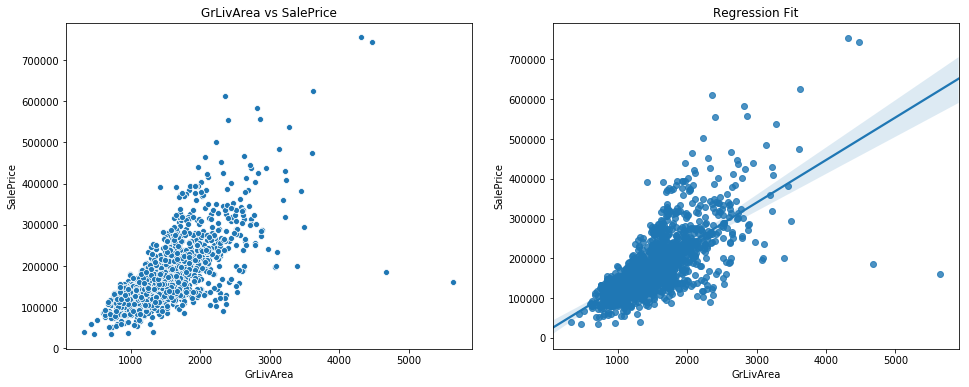

In [183]:
# TODO: code to generate Plot 3
scatter_data = df1[['SalePrice','GrLivArea']]
plt.figure(figsize= (16,6))
plt.subplot(1,2,1)
plt.title('GrLivArea vs SalePrice')
sns.scatterplot(x=  df.GrLivArea, y = df.SalePrice)
plt.subplot(1,2,2)
sns.regplot(x="GrLivArea", y="SalePrice", data=scatter_data)
plt.title('Regression Fit')
plt.show()

What interesting properties does Plot 3 reveal?

From the scatter plot on the left, it is very interesting to see that the sale price varies almost linearly with the Ground Living Area of a house, barring a few outliers. Intuitively, this does make sense as one would expect a house to become more expensive as its living area does become larger. We might expect these outliers to be in certain neighborhoods where the cost of houses is lower on an average or vice versa, due to environmental conditions of the neighborhood. However, on a general basis, we can safely assume that the price of a house increases linearly with the Living Area.To visualize this even better, I created a regression plot with seaborn which is shown on the right.

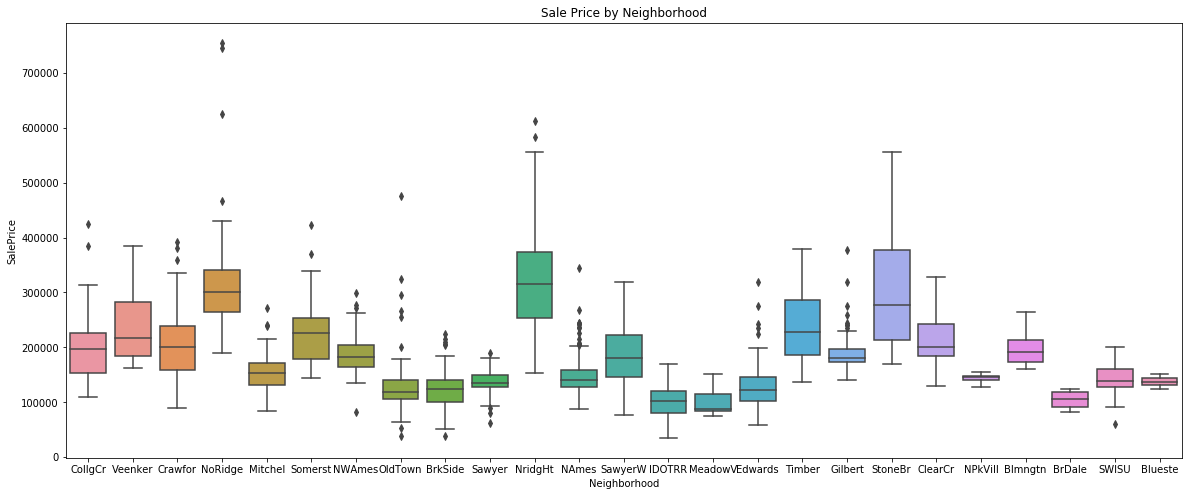

In [14]:
# TODO: code to generate Plot 4
box_data = df1[['SalePrice', 'Neighborhood']]
plt.figure(figsize = (20,8))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = box_data)
plt.title('Sale Price by Neighborhood')
plt.show()

What interesting properties does Plot 4 reveal?

From the above boxplot, we can see the distribution of the selling prices of the houses based on the neighborhood they are in. From the chart, we can clearly see that, on average, NridgHt and StoneBr contain the most expensive houses and this is probably because they are the richer neighborhoods. We can also see the presence of outliers in NoRidge neighborhood with three houses being sold for greater than 600K dollars. This boxplot gives us an idea of how the neighborhoods are distributed with respect to the housing market.

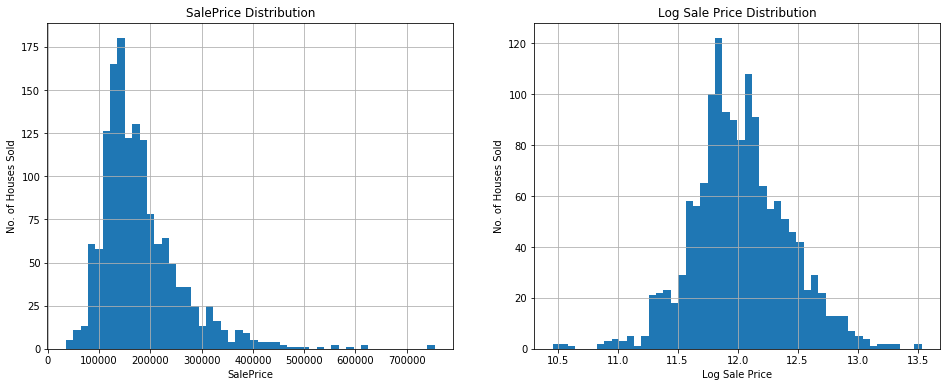

In [24]:
# TODO: code to generate Plot 5
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.title('SalePrice Distribution')
df1.SalePrice.hist(bins = 50)
plt.xlabel('SalePrice')
plt.ylabel('No. of Houses Sold')
plt.subplot(1,2,2)
plt.title('Log Sale Price Distribution')
plt.xlabel('Log Sale Price')
plt.ylabel('No. of Houses Sold')
np.log(df1.SalePrice).hist(bins = 50)
plt.show()

What interesting properties does Plot 5 reveal?
From the first distribution, we can see that the majority of the houses are concentrated in the range of 100k to 200k dollars selling price. We can also observe the presence of quite a few outliers(450k+). To get a curve which somewhat resembles a normal distribution, we can observe the same distribution on a logarithmic scale. Here, in the second chart, we can see the effects of applying a log transform on the Selling Price. I considered applying this log transform for my predictions in further steps of the assignment. 

## Part 3 - Handcrafted Scoring Function

In [0]:
# TODO: code for scoring function
cols = ['LotArea', 'YearBuilt', 'BedroomAbvGr', 'FullBathrooms', 'HalfBathrooms', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond',
 'KitchenAbvGr', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'YearRemodAdd']
features = df1[cols]
z_array = features.apply(zscore)
z_array.shape


corr_vals = np.array(df_heatmap.corr())[0][1:]
corr_vals = np.reshape(corr_vals, (14,1)).transpose()
scores = np.dot(corr_vals, z_array.transpose()).transpose()
df1['Score'] = scores
df_sorted = df1.sort_values(by = 'Score', ascending = False)


What is the ten most desirable houses?

In [44]:
#Ten Most Desirable Houses
df_sorted.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,FullBathrooms,HalfBathrooms,Score
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000,4,1,22.896408
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750,4,1,17.054769
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,4,1,14.569142
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,3,2,14.002319
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,4,1,12.815387
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000,4,1,12.365033
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933,3,1,10.935110
798,799,60,RL,104.0,13518,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,860.0,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1926,1926,GasA,Ex,Y,SBrkr,1966,1174,0,3140,4,1,Ex,11,Typ,2,Gd,BuiltIn,2009.0,Fin,3,820,TA,TA,Y,144,78,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,485000,3,1,10.869012
1142,1143,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,Stone,340.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1150,Unf,0,316,1466,GasA,Ex,Y,SBrkr,1466,1362,0,2828,4,1,Gd,11,Typ,1,TA,BuiltIn,2006.0,RFn,3,1052,TA,TA,Y,125,144,0,0,0,0,NaN,NaN,NaN,0,4,2007,New,Partial,424870,4,0,10.072744
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,

What is the ten least desirable houses?

In [13]:
#Ten Least Desirable Houses
df_sorted.tail(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,FullBathrooms,HalfBathrooms,Score
1323,1324,30,RL,50.0,5330,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,4,7,1940,1950,Hip,CompShg,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,TA,TA,No,LwQ,280,Unf,0,140,420,GasA,Gd,Y,SBrkr,708,0,0,708,2,1,Fa,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,164,0,0,0,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal,82500,1,0,-7.908476
1337,1338,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,Corner,Mod,OldTown,Feedr,Norm,1Fam,1Story,4,4,1941,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,693,693,Grav,Fa,N,FuseA,693,0,0,693,2,1,Fa,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,20,0,0,0,0,NaN,NaN,NaN,0,3,2006,WD,Normal,52500,1,0,-8.085471
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,Fa,N,SBrkr,600,368,0,968,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900,1,0,-8.135249
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900,1,0,-8.340950
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,4,6,1927,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,520,520,GasA,Fa,N,SBrkr,520,0,0,520,1,1,Fa,4,Typ,0,NaN,Detchd,1920.0,Unf,1,240,Fa,TA,Y,49,0,87,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,68500,1,0,-8.420383
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,1,TA,4,Typ,0,NaN,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311,1,0,-8.821224
375,376,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000,1,1,-8.903190
636,637,30,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,2,3,1936,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,Fa,Fa,BrkTil,TA,Fa,No,Unf,0,Unf,0,264,264,Grav,Fa,N,FuseA,800,0,0,800,1,1,Fa,4,Maj1,1,Po,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2009,ConLw,Normal,60000,1,0,-9.087579
1100,1101,30,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1Story,2,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,Fa,No,Rec,290,Unf,0,0,290,GasA,TA,N,FuseF,438,0,0,438,1,1,Fa,3,Typ,0,NaN,Detchd,1930.0,Unf,1,246,TA,TA,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2009,WD,Normal,60000,1,0,-10.111136
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,1,1,

Describe your scoring function and how well you think it worked.

Ans: To develop my scoring function, I used most of the features which I used to show the heat-map in the first task. The key to my scoring function was the pairwise correlations of these columns with SalePrice of the house. The intuition behind my scoring function was to use these higher weights for the more strongly correlated columns and calculate a desirability score on this basis. For the most part, my scoring function seemed to perform pretty well. The most expensive houses did show up in the top 10 most desirable houses based on score and the least expensive on the 10 least desirable. One place where my scoring function failed to work is to account for outliers. It was merely checking the numerical variables and did not account for the categorical variables at all. For example, the house which received the highest score was actually only sold for 160K dollars which was ranked at number 750 with respect to selling price. Upon further inspection, I realized that although this house had high quality,a lot of rooms, and a large living area, the sale condition was a partial sale which means that it was not fully completed when it was sold. This might have been a reason due to which it did not sell for too large a price.

## Part 4 - Pairwise Distance Function

In [184]:
# TODO: code for distance function

cols1 = ['GrLivArea', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'FullBathrooms', 'HalfBathrooms', 'OverallQual', 'OverallCond', 'GarageArea', 
         'GarageCars', 'TotalBsmtSF']

df_dist = df_sorted[cols1]

ct = ColumnTransformer([
        ('Transform', StandardScaler(), ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF'])
    ], remainder='passthrough')


norm_df = pd.DataFrame(ct.fit_transform(df_dist[cols1]))



distances = pdist(norm_df.values, metric='seuclidean')
dist_matrix = squareform(distances)
distance_df = pd.DataFrame(dist_matrix)

df_test = distance_df.head(10)
df_test = df_test.append(distance_df.tail(10))
print(df_test)

# dist_matrix = DistanceMetric.get_metric('mahalanobis', V = np.cov(norm_df.transpose()))

# df_test = norm_df.head(10)
# df_test = df_test.append(norm_df.tail(10))

# pd.DataFrame(dist_matrix.pairwise(df_test))

           0          1          2     ...       1457       1458       1459
0      0.000000   8.697883  11.368538  ...  22.376009  22.713567  24.134083
1      8.697883   0.000000   2.913457  ...  15.962889  16.192138  17.719003
2     11.368538   2.913457   0.000000  ...  14.602819  14.723285  16.236783
3     11.455151   3.626193   2.499394  ...  14.561833  14.555841  16.193679
4     13.247052   4.884150   2.523909  ...  12.966713  12.916003  14.517765
5     14.042208   5.926669   4.046029  ...  12.194426  12.125171  13.764034
6     13.949454   6.333621   5.010051  ...  11.863973  11.667702  13.472435
7     13.266303   5.342400   3.983884  ...  11.809087  11.753183  13.481096
8     14.889910   7.192235   5.465877  ...  11.524886  11.220196  12.985747
9     10.376770   5.486191   6.674020  ...  13.104977  13.498020  14.937480
1450  21.888901  15.371076  13.986779  ...   3.950223   3.284747   4.836509
1451  21.632437  15.243548  13.889063  ...   1.993280   2.811799   3.294153
1452  21.492

How well does the distance function work? When does it do well/badly?

Above, I have appended the top 10 and bottom 10 houses based on the scoring function I developed in the previous task. In particular, I could see that the scoring function showed similar scores to similar properties barring a few exceptional cases. Therefore, according to this, my distance function would have to report minimal distances between houses with the same score. However, I did not want to include score in my distance function and added some other features such as number of cars in the garage. The above matrix shows the pairwise distances for the top 10 and bottom 10 scored houses respectively. We can see that the top 10 houses have minimal distance with respect to each other and maximal distance with respect to the bottom 10 houses, for the most part. One place where my function did poorly was with respect to the very first row in the distance matrix. In addition, the prices of the houses in the middle of the dataset(sorted by prices) did not fare too well with my distance function because although they had similar rooms and square footage, other categorical properties were not considered which should have separated these houses, distance-wise.

## Part 5 - Clustering

In [0]:
# TODO: code for clustering and visualization
S = 1 - (dist_matrix / np.max(dist_matrix))

# db = DBSCAN().fit(S)
# #db = AffinityPropagation(preference=-50).fit(S)

# labels = db.labels_

# n = len(set(labels)) 
# print(n)

In [0]:
from sklearn.manifold import TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.061s...
[t-SNE] Computed neighbors for 1460 samples in 5.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 0.455626
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.370441
[t-SNE] KL divergence after 300 iterations: 0.759965


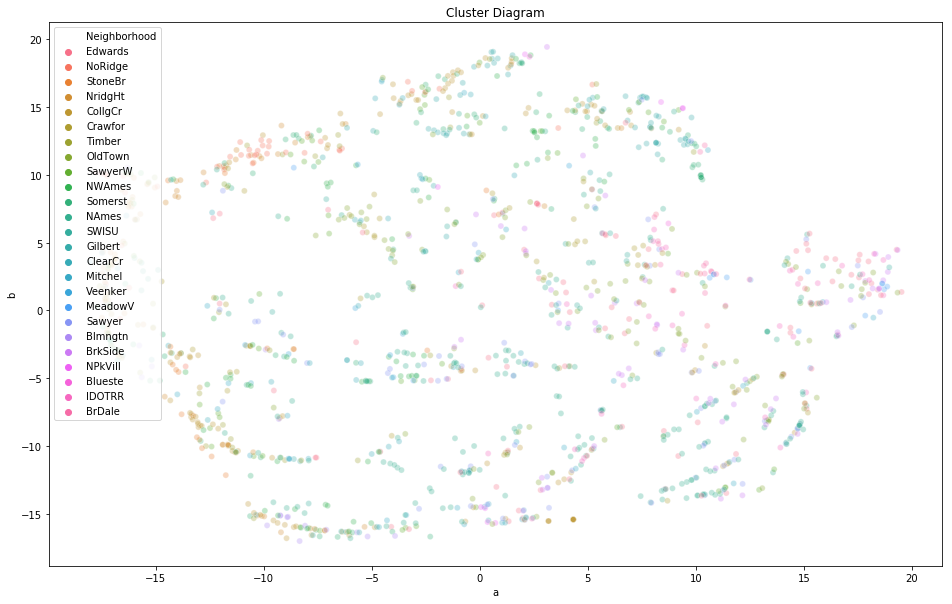

In [182]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(S)
df_sorted['a'] = tsne_results[:,0]
df_sorted['b'] = tsne_results[:,1]
# a = tsne_results[:,0]
# b = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="a", y="b",
    hue = "Neighborhood" ,
    palette=sns.color_palette("husl", 25),
    data = df_sorted,
    legend="full",
    alpha=0.3
)
plt.title('Cluster Diagram')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

How well do the clusters reflect neighborhood boundaries? Write a discussion on what your clusters capture and how well they work.


I think the clusters represent neighborhood boundaries fairly well. First of all, I think that the extreme neighborhoods (those which have the richest and poorest houses) are clustered very well together as the distance function was able to capture these clusters fairly accurately. As you can see from the plot, the clusters with pink at the mid-right of the diagram and the clusters with red to the top left represent the poorest and richest neighborhoods respectively. The clusters did not do too well with respect to the average households, as the distance matrix itself did not fare too well in those scenarios.



## Part 6 - Linear Regression

RMSLE error:0.2186937298338453


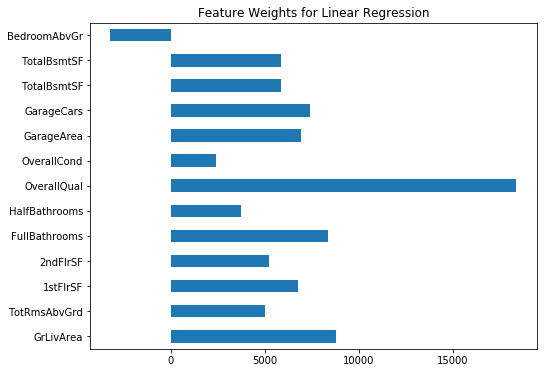

In [54]:
simple_cols =  ['GrLivArea', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'FullBathrooms', 'HalfBathrooms', 'OverallQual', 'OverallCond', 'GarageArea', 
         'GarageCars', 'TotalBsmtSF', 'TotalBsmtSF', 'BedroomAbvGr']
df_simple  = df1[simple_cols]
y_simple = df1.SalePrice
scale_cols = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF']
for scale_col in scale_cols:
  df_simple[scale_col] = (df_simple[scale_col] - df_simple[scale_col].mean())/df_simple[scale_col].std()
#df_simple = pd.concat([df_simple,pd.get_dummies(df_simple['Neighborhood'], prefix='Neighborhood',dummy_na=True)],axis=1).drop(['Neighborhood'],axis=1)

x1_train, x1_test,y1_train, y1_test = train_test_split(df_simple,y_simple,test_size = 0.3)
reg = ElasticNet()
reg.fit(x1_train,y1_train)
simple_preds = reg.predict(x1_test)

error = np.sqrt(mean_squared_log_error(y1_test, simple_preds))
print("RMSLE error:" + str(error))
feature_weights = pd.Series(reg.coef_, index = x1_train.columns)
feature_weghts = feature_weights.sort_values()
plt.figure(figsize = (8,6))
feature_weights.plot(kind = 'barh')
plt.title('Feature Weights for Linear Regression')
plt.show()


How well/badly does it work? Which are the most important variables?

---

For my simple linear regression model, I decided to use only the highly correlated numerical features available in the dataset, and I ignored all of the other features. I knew that my model would perform poorly but this was the most straight-forward implementation that I could decide on doing. However, the feature coefficients were clearly directly related to the correlation coefficients with SalePrice earlier seen in the heatmap. Overall Quality, Bedrooms Above Ground Level, Ground Living Area, and number of cars in the garage all seemed to be very important features used in fitting the data. I decided to buiild a more sophisticated model later on as shown in the end of this notebook.

## Part 7 - External Dataset

In [51]:
# TODO: code to import external dataset and test
df_ext = pd.read_csv('external_data.csv')

drop_cols  = ['BldgNo_S', 'ParType', 'DwlgNo_S']
df_ext.drop(drop_cols, axis = 1, inplace = True)

ext_cols = df_ext.columns
df1_new = df1[ext_cols]
df_total = pd.concat([df1_new,df_ext])

df_total.drop('GarageYrBlt', axis = 1, inplace = True)
df_total['MasVnrType'].fillna(df_total['MasVnrType'].mode()[0], inplace= True)
df_total['GarageType'].fillna('No Garage', inplace = True)
df_total = df_total.sample(frac=1).reset_index(drop=True)

num_cols = ['TotalBsmtSF', 'GrLivArea', 'LotArea', 'GarageArea']
for num_col in num_cols:
  df_total[num_col] = (df_total[num_col] - df_total[num_col].mean())/df_total[num_col].std()
#OneHot Encoding for all categorical variables
for cat_col in df_total.dtypes[df_total.dtypes == 'object'].index:
  df_total = pd.concat([df_total, pd.get_dummies(df_total.pop(cat_col), prefix=cat_col)], axis=1)
y_total = df_total['SalePrice']
df_total.drop('SalePrice', axis = 1, inplace = True)
#print(df_total.shape)
x_train, x_test, y_train, y_test = train_test_split(df_total, y_total, test_size = 0.3)

#clf = RandomForestRegressor(n_estimators = 300)
clf = ElasticNet()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

error = np.sqrt(mean_squared_log_error(y_test, preds))
print('RMSLE Error is:' + str(error))

RMSLE Error is:0.6108286038336544


Describe the dataset and whether this data helps with prediction.

I found the most recent real estate listings dataset uploaded on the government website of the City of Ames, Iowa at this link: https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/reports
This dataset contained a lot of data for up to 2019 of properties sold in the city of Ames. However, I did see an immediate problem with this dataset. Fields that were included in the kaggle dataset such as Overall Quality, Overall Condition, Number of Bathrooms, were actually not included in the external dataset which I found. However, it did have 2500+ training examples for houses sold in Ames, Iowa and it was very easy to merge this with my original dataframe. However, due to the fact that I had to drop many highly correlated features because of non-existence in the new dataset, my model did worse than the original model with a RMSLE of 0.61. Therefore, I decided not to use this dataset any further as highly correlated features are more important than many training examples with poorly correlated features.

## Part 8 - Permutation Test

In [143]:
# TODO: code for all permutation tests
from sklearn.model_selection import permutation_test_score

p_cols = ['GrLivArea', 'FullBathrooms', 'BedroomAbvGr', 'OverallQual', 'OverallCond', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'HalfBathrooms'
          , 'TotRmsAbvGrd']
df_p_test = df1[p_cols]
x1,x2,y1,y2 = train_test_split(df_p_test, y_simple, test_size = 0.3)

reg = GradientBoostingRegressor(loss = 'ls')
p_vals = []
# df_p = df1
# sp = df_p.SalePrice
# df_p.drop('SalePrice', axis = 1 , inplace = True)
# df_p = df_p.select_dtypes(include=[np.number])
# x_train,x_test, y_train, y_test = train_test_split(df_p,y_simple)
# df_p.drop(['Id', 'LotFrontage', 'GarageYrBlt'], axis = 1, inplace = True)
# df_p['MasVnrArea'].fillna(0, inplace = True)
# df_p.isnull().sum()
for p_col in p_cols:
  df_p = np.array(x1[p_col]).reshape((-1,1))
  score,pscore,pvalue = permutation_test_score(reg.fit(df_p,y1),x1_train ,y1_train, scoring="neg_mean_squared_error",cv=None, 
                                               n_permutations=100, n_jobs=-1 )
  p_vals.append(pvalue)
print(p_vals)

[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901]


Describe the results.

Based on the results, we can see that every feature I selected is strongly correlated with the final output due to their low P-values. This was expected becuase the features with which I built single-variable regression models were seen to be highly correlated with the Sale Price, from the heatmap.  

## Part 9 - Final Result

In [155]:
# TODO: code for linear regression
df1 = df1.sort_values(by = 'Id')
df2 = pd.read_csv('test.csv')
#print(df2.shape)
df2.drop(['Alley'], axis = 1,inplace = True)
df2['BsmtFullBath'].fillna(0, inplace = True)
df2['BsmtHalfBath'].fillna(0, inplace = True)
df2['FullBathrooms'] = df2['FullBath'] + df2['BsmtFullBath']
df2['HalfBathrooms'] = df2['HalfBath'] + df2['BsmtHalfBath']
df2.drop('FullBath', axis=1, inplace = True)
df2.drop('HalfBath', axis=1, inplace = True)
df2.drop('BsmtFullBath', axis=1, inplace = True)
df2.drop('BsmtHalfBath', axis=1, inplace = True)


df_numerical = pd.concat([df1,df2], keys = ['train', 'test'])
y = df1.SalePrice

df_numerical.drop(['LotFrontage', 'GarageYrBlt', 'SalePrice', 'MasVnrArea', 'Score', 'Utilities', 'RoofMatl', 'Heating', 'PoolArea', 'PoolQC', 'Fence', 
                   'MiscFeature', 'MiscVal'], axis= 1, inplace = True)

# df_numerical['Bathrooms'] = df['Fu|llBathrooms'] + (0.5*df['HalfBathrooms'])
# df_numerical.drop(['FullBathrooms', 'HalfBathrooms'], axis= 1, inplace = True)

df_numerical['BsmtFinSF1'].fillna(0, inplace = True)
df_numerical['BsmtFinSF2'].fillna(0, inplace = True)
df_numerical['TotalBsmtSF'].fillna(0, inplace = True)
df_numerical['BsmtUnfSF'].fillna(0, inplace = True)


df_numerical['SquareFootage'] = df_numerical['TotalBsmtSF'] + df_numerical['1stFlrSF'] + df_numerical['2ndFlrSF']
df_numerical.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis= 1, inplace = True)



df_numerical['FireplaceQu'].fillna('None', inplace= True)

#Since All the Basement fields have almost the same number of missing value fields, I have assumed that these houses dont have a basement
df_numerical['BsmtCond'].fillna('No Basement', inplace = True)
df_numerical['BsmtExposure'].fillna('No Basement', inplace = True)
df_numerical['BsmtFinType1'].fillna('No Basement', inplace = True)
df_numerical['BsmtFinType2'].fillna('No Basement', inplace = True)
df_numerical['BsmtFinType2'].fillna('No Basement', inplace = True)
df_numerical['BsmtFinType2'].fillna('No Basement', inplace = True)
df_numerical['BsmtQual'].fillna('No Basement', inplace = True)

#Similar Logic with Garage Fields
df_numerical['GarageCond'].fillna('No Garage', inplace= True)
df_numerical['GarageFinish'].fillna('No Garage', inplace= True)
df_numerical['GarageQual'].fillna('No Garage', inplace= True)
df_numerical['GarageType'].fillna('No Garage', inplace= True)


df_numerical['GarageCars'].fillna(0, inplace= True)
df_numerical['GarageArea'].fillna(0, inplace= True)

df_numerical['MSZoning'] = df_numerical['MSZoning'].astype(str)
#Since the number of missing values are very small for MSZoning, I imputed with the mode
df_numerical['MSZoning'].fillna(df_numerical['MSZoning'].mode()[0], inplace= True)
df_numerical['Electrical'].fillna(df_numerical['Electrical'].mode()[0], inplace= True)
df_numerical['MSZoning'].fillna(df_numerical['MSZoning'].mode()[0], inplace= True)
df_numerical['MSZoning'].fillna(df_numerical['MSZoning'].mode()[0], inplace= True)

df_numerical['KitchenQual'].fillna(df_numerical['KitchenQual'].mode()[0], inplace= True)
df_numerical['SaleType'].fillna(df_numerical['SaleType'].mode()[0], inplace= True)


df_numerical['Exterior1st'].fillna(df_numerical['Exterior1st'].mode()[0], inplace= True)
df_numerical['Exterior2nd'].fillna(df_numerical['Exterior2nd'].mode()[0], inplace= True)

df_numerical['Functional'].fillna(df_numerical['Functional'].mode()[0], inplace= True)

df_numerical['MasVnrType'].fillna(df_numerical['MasVnrType'].mode()[0], inplace= True)

#OneHot Encoding for all categorical variables
for cat_col in df_numerical.dtypes[df_numerical.dtypes == 'object'].index:
  df_numerical = pd.concat([df_numerical, pd.get_dummies(df_numerical.pop(cat_col), prefix=cat_col)], axis=1)

numerical_cols = ['SquareFootage', 'GrLivArea', 'LotArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 
                  'YearBuilt', 'YearRemodAdd', 'YrSold', '3SsnPorch']
for col in numerical_cols:
  df_numerical[col] = (df_numerical[col] - df_numerical[col].mean()) / df_numerical[col].std()

X = df_numerical.loc['train'].drop('Id', axis= 1)
X_test = df_numerical.loc['test'].drop('Id', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)




#df_numerical = (df_numerical - df_numerical.mean())/df_numerical.std()
#clf = RandomForestRegressor(n_estimators = 300)
#clf = Ridge(alpha = 0.1)
#clf = ElasticNet()
clf = GradientBoostingRegressor(loss = 'huber')
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

error = np.sqrt(mean_squared_log_error(y_test, preds))
print("RMS of Log Error is :" + str(error))

# feature_weights = pd.Series(clf.coef_, index = x_train.columns)
# feature_weghts = feature_weights.sort_values()
# plt.figure(figsize = (8,6))
# feature_weights.plot(kind = 'barh')
# plt.title('Feature Weights for Ridge Regression')
# plt.show()

#clf_final = RandomForestRegressor(n_estimators = 300)
clf_final = GradientBoostingRegressor(loss = 'huber')

clf_final.fit(X, y)
final_preds = clf_final.predict(X_test)

pd.DataFrame({'Id': df2.Id, 'SalePrice': final_preds}).to_csv('submission.csv', index =False)





RMS of Log Error is :0.13765400216398346


Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/saketh03

Highest Rank: 1699

Score: 0.12828

Number of entries: 4

INCLUDE IMAGE OF YOUR KAGGLE RANKING




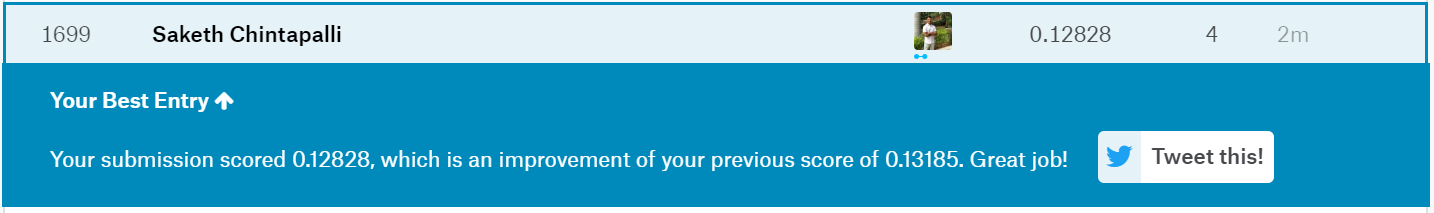

In [163]:
from IPython.display import Image
Image(filename = 'dsfrank.PNG')